In [20]:
import sys
import os

# Set root path relative to this notebook (notebooks/run_model.ipynb)
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import halfnorm, beta
%matplotlib inline

from model.bayesian_mmm import build_mmm_model

In [21]:
# Load the saved posterior trace
trace = az.from_netcdf(os.path.join(project_root,"trace/trace_with_lag_binflag_dif_priors_adstock_length.nc"))

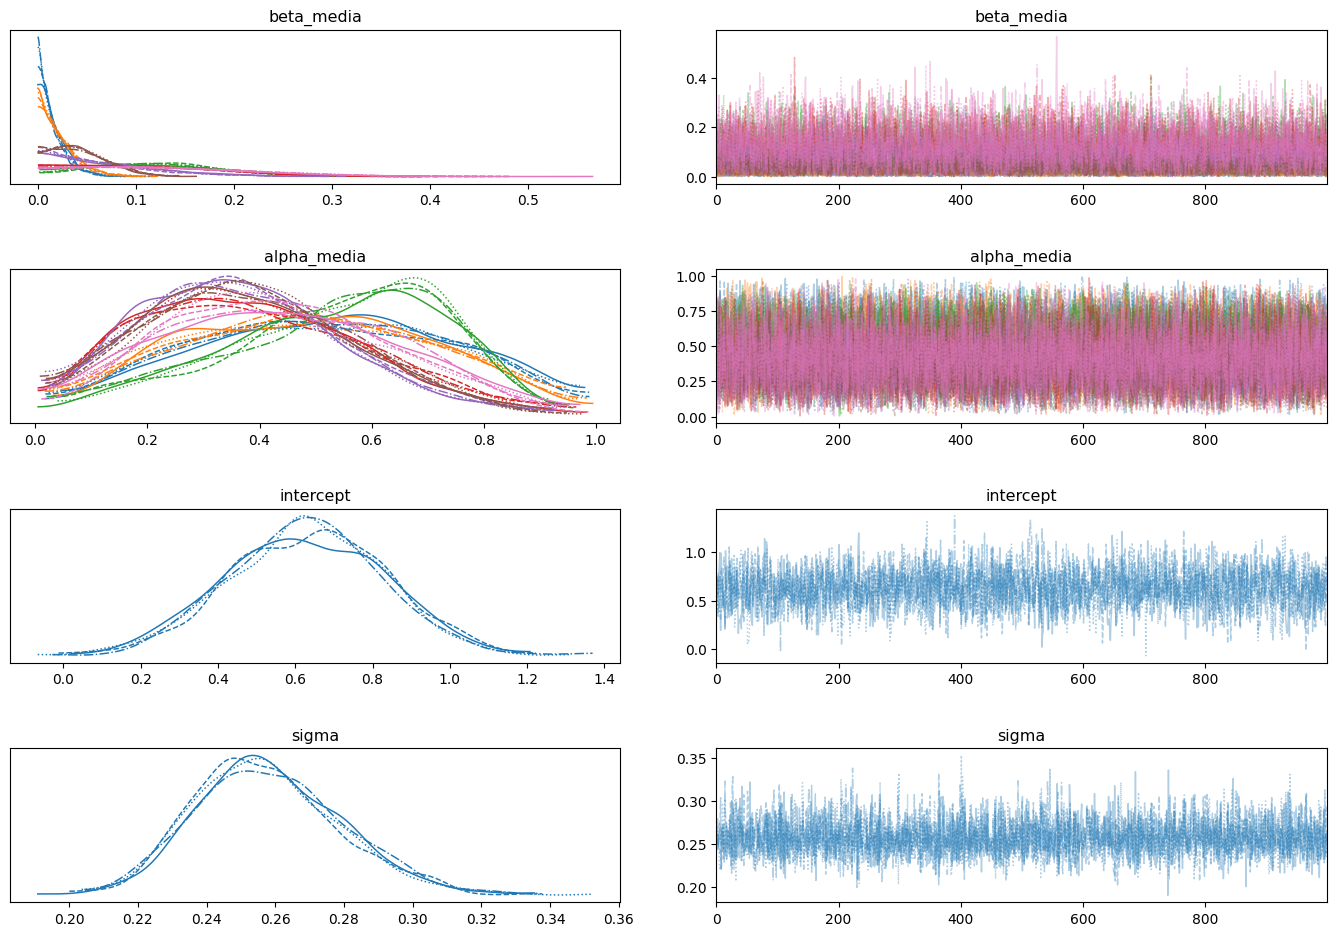

In [22]:
# Create trace plot
az.plot_trace(trace, var_names=["beta_media", "alpha_media", "intercept", "sigma"], figsize=(14, 10))

# Add spacing between subplots
plt.tight_layout(pad=3.0)  # Increase padding between plots
plt.show()

array([[<Axes: title={'center': 'beta_media\n0'}>,
        <Axes: title={'center': 'beta_media\n1'}>,
        <Axes: title={'center': 'beta_media\n2'}>,
        <Axes: title={'center': 'beta_media\n3'}>],
       [<Axes: title={'center': 'beta_media\n4'}>,
        <Axes: title={'center': 'beta_media\n5'}>,
        <Axes: title={'center': 'beta_media\n6'}>,
        <Axes: title={'center': 'alpha_media\n0'}>],
       [<Axes: title={'center': 'alpha_media\n1'}>,
        <Axes: title={'center': 'alpha_media\n2'}>,
        <Axes: title={'center': 'alpha_media\n3'}>,
        <Axes: title={'center': 'alpha_media\n4'}>],
       [<Axes: title={'center': 'alpha_media\n5'}>,
        <Axes: title={'center': 'alpha_media\n6'}>, <Axes: >, <Axes: >]],
      dtype=object)

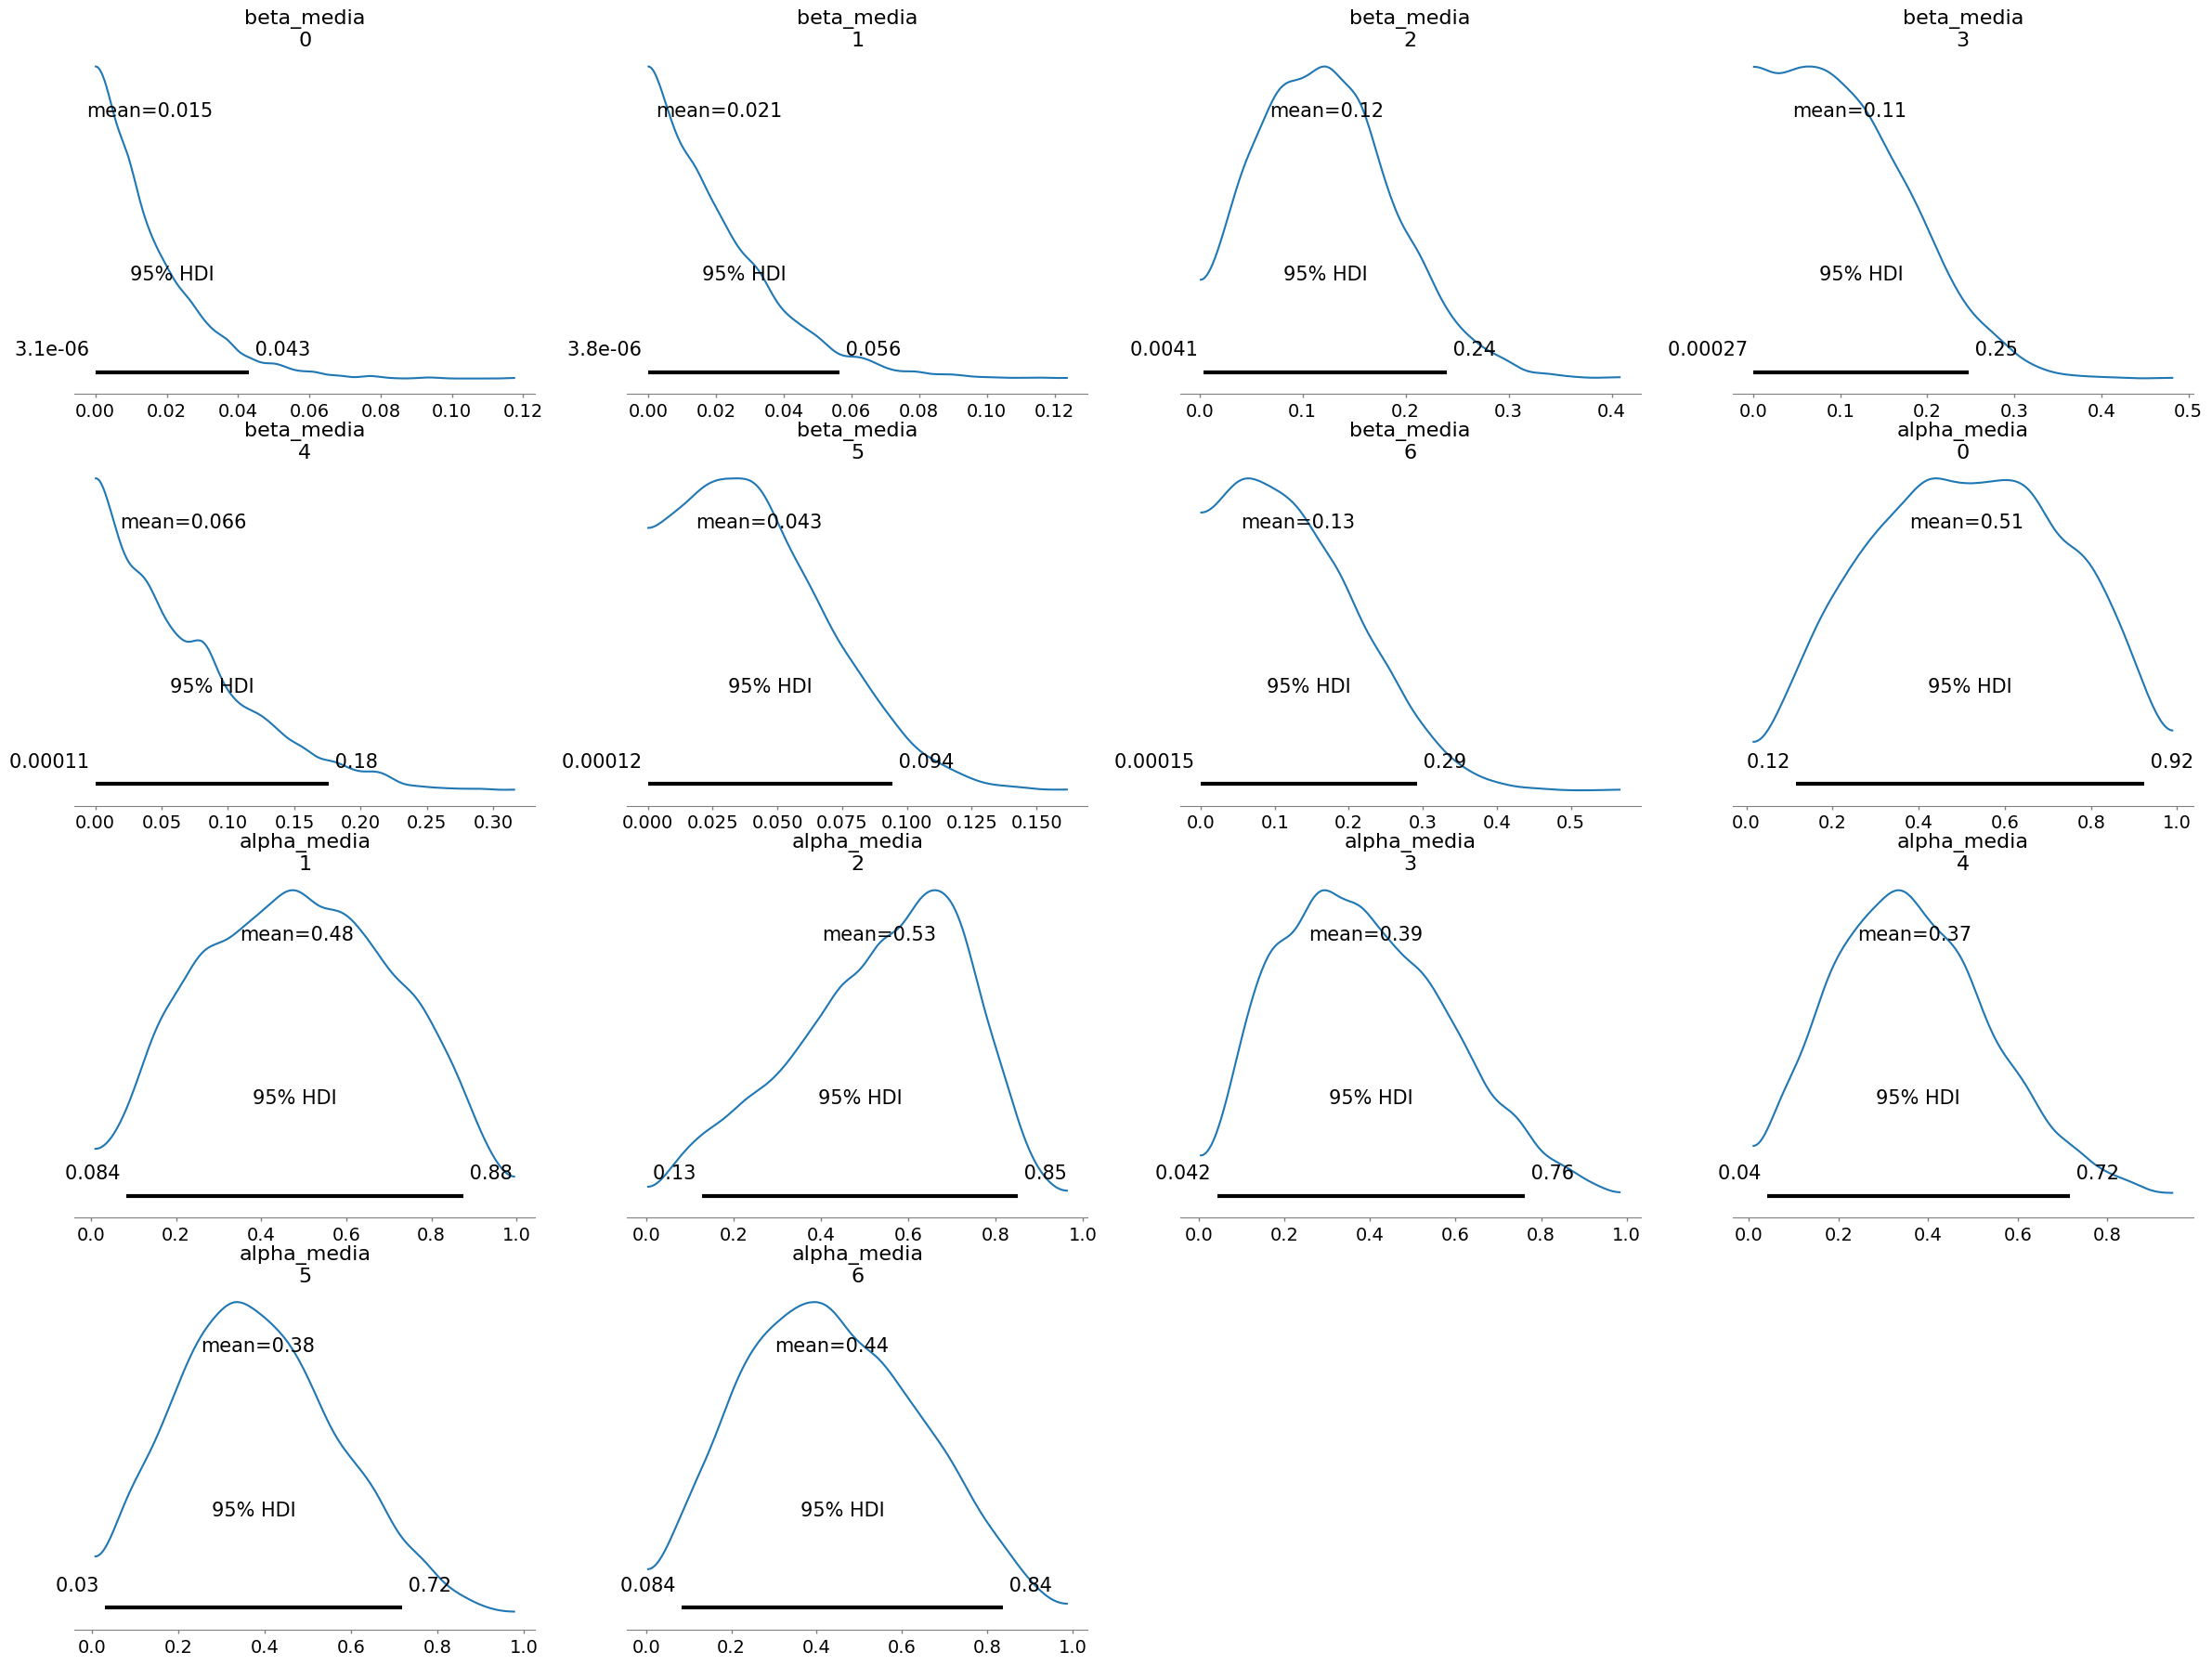

In [23]:
az.plot_posterior(trace, var_names=["beta_media", "alpha_media"], hdi_prob=0.95)

In [24]:
summary = az.summary(trace, var_names=["beta_media", "alpha_media", "intercept", "sigma"])

summary.to_csv(os.path.join(project_root,"output_files/mmm_summary.csv"))

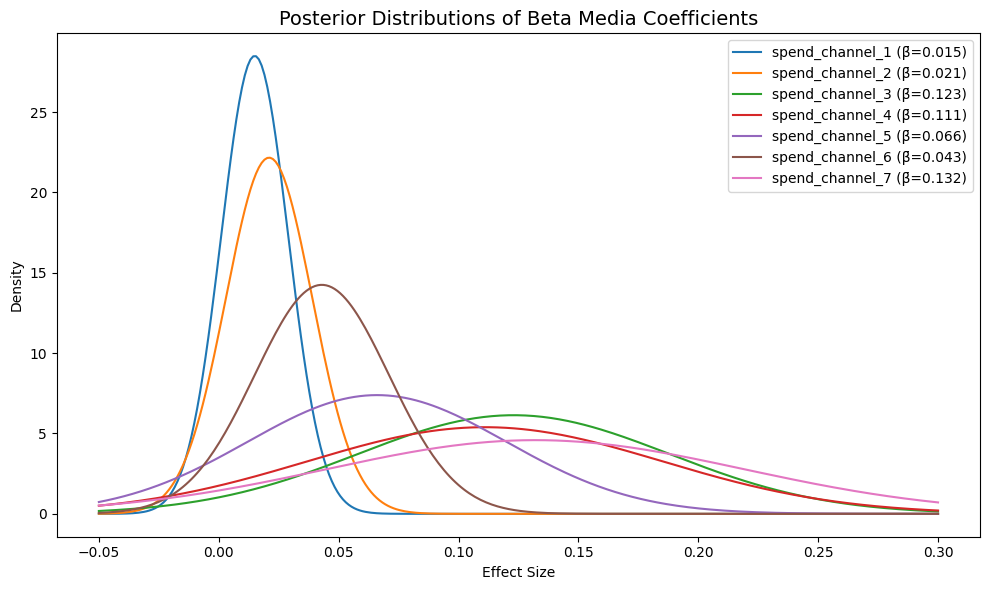

In [28]:

summary = pd.read_csv(os.path.join(project_root,"output_files/mmm_summary.csv"))
beta_subset = summary[summary["Unnamed: 0"].str.contains("beta_media")].head(7)
beta_subset.set_index("Unnamed: 0", inplace=True)

# Plot KDEs
x = np.linspace(-0.05, 0.3, 300)
fig, ax = plt.subplots(figsize=(10, 6))
for i, (param, row) in enumerate(beta_subset.iterrows()):
    mu, sigma = row["mean"], row["sd"]
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax.plot(x, y, label=f"spend_channel_{i+1} (β̄={mu:.3f})")

ax.set_title("Posterior Distributions of Beta Media Coefficients", fontsize=14)
ax.set_xlabel("Effect Size")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()


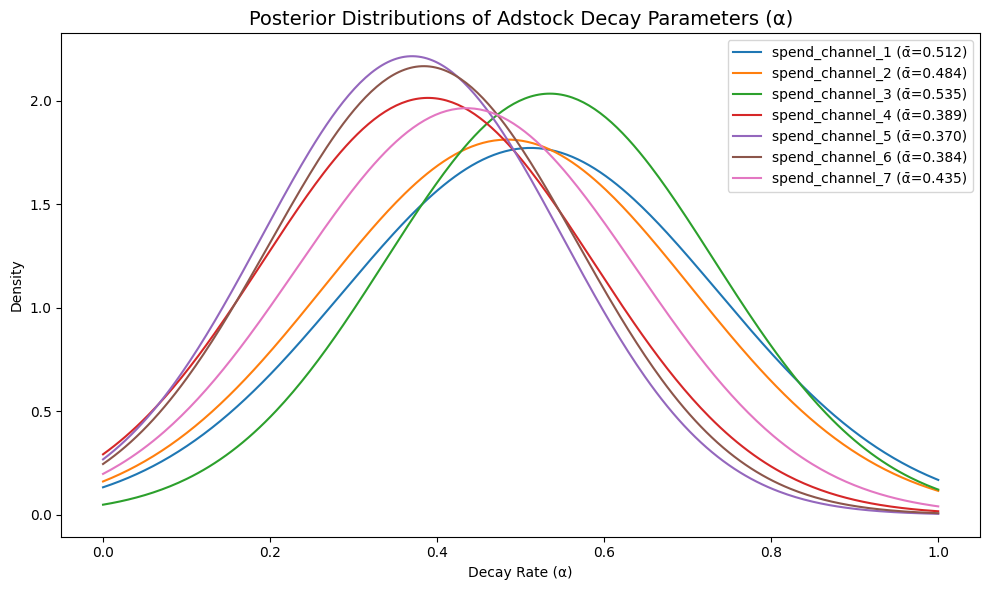

In [27]:
# Select a few alpha_media parameters
alpha_subset = summary[summary["Unnamed: 0"].str.contains("alpha_media")].head(7)
alpha_subset.set_index("Unnamed: 0", inplace=True)

# Plot approximate posterior densities
x = np.linspace(0, 1, 300)  # Since alpha is bounded [0,1]
fig, ax = plt.subplots(figsize=(10, 6))

for i, (param, row) in enumerate(alpha_subset.iterrows()):
    mu, sigma = row["mean"], row["sd"]
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax.plot(x, y, label=f"spend_channel_{i+1} (ᾱ={mu:.3f})")

ax.set_title("Posterior Distributions of Adstock Decay Parameters (α)", fontsize=14)
ax.set_xlabel("Decay Rate (α)")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()


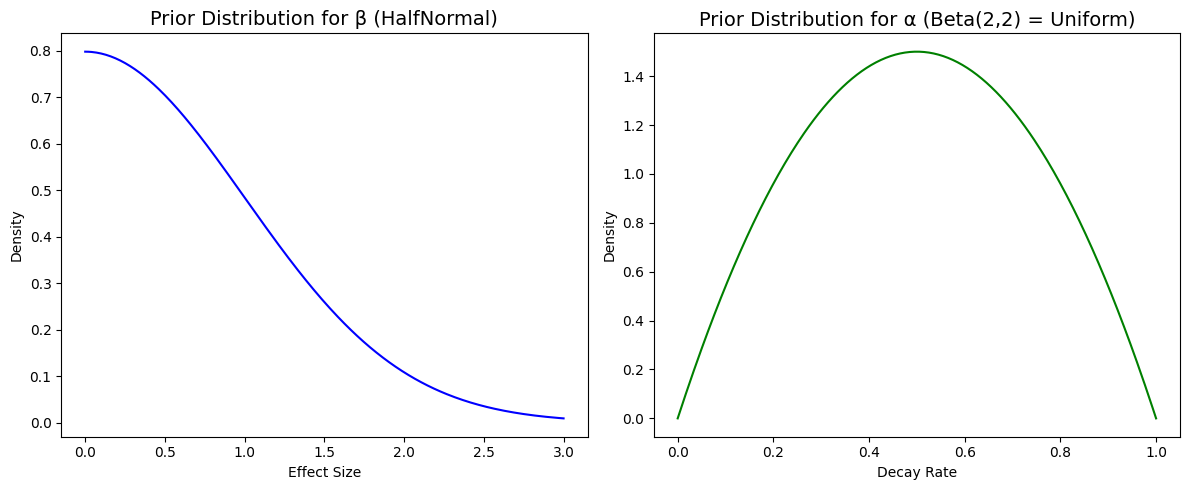

In [31]:
# 1. Prior for beta_media (HalfNormal)
sigma_estimate = 1.0  # Approximate σ; you can adjust this
x_beta = np.linspace(0, 3 * sigma_estimate, 300)
prior_beta = halfnorm(scale=sigma_estimate).pdf(x_beta)

# 2. Prior for alpha_media (Beta(1, 1) = Uniform[0,1])
x_alpha = np.linspace(0, 1, 300)
prior_alpha = beta(2, 2).pdf(x_alpha)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot beta prior
axs[0].plot(x_beta, prior_beta, color='blue')
axs[0].set_title("Prior Distribution for β (HalfNormal)", fontsize=14)
axs[0].set_xlabel("Effect Size")
axs[0].set_ylabel("Density")

# Plot alpha prior
axs[1].plot(x_alpha, prior_alpha, color='green')
axs[1].set_title("Prior Distribution for α (Beta(2,2) = Uniform)", fontsize=14)
axs[1].set_xlabel("Decay Rate")
axs[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

<xarray.Dataset> Size: 512B
Dimensions:            (beta_lags_dim_0: 14, beta_binary_dim_0: 2,
                        beta_media_dim_0: 7, alpha_media_dim_0: 7)
Coordinates:
  * beta_lags_dim_0    (beta_lags_dim_0) int64 112B 0 1 2 3 4 ... 9 10 11 12 13
  * beta_binary_dim_0  (beta_binary_dim_0) int64 16B 0 1
  * beta_media_dim_0   (beta_media_dim_0) int64 56B 0 1 2 3 4 5 6
  * alpha_media_dim_0  (alpha_media_dim_0) int64 56B 0 1 2 3 4 5 6
Data variables:
    intercept          float64 8B 1.001
    beta_trend         float64 8B 1.001
    beta_peak          float64 8B 1.002
    beta_lags          (beta_lags_dim_0) float64 112B 1.0 1.001 ... 1.0 1.0
    beta_binary        (beta_binary_dim_0) float64 16B 1.0 1.002
    beta_media         (beta_media_dim_0) float64 56B 1.004 1.001 ... 1.001
    alpha_media        (alpha_media_dim_0) float64 56B 1.0 1.0 ... 1.001 1.001
    sigma              float64 8B 1.002

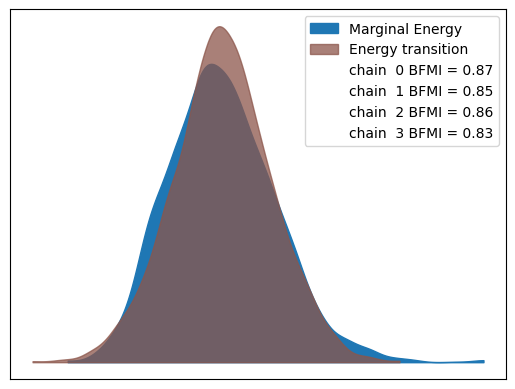

In [11]:
az.plot_energy(trace)  # NUTS sampler energy diagnostic
az.rhat(trace)         # R-hat values (should be ~1.0)

In [ ]:
# Calculate ROI according to beta posteriors mean, beta standard deviation, HDI 3% and HDI 97 %

# Load model summary and test data
raw_df = pd.read_csv(os.path.join(project_root,"data/raw/MMM_test_data.csv"))      # Unscaled spend
processed_df = pd.read_csv(os.path.join(project_root,"data/processed/mmm_processed_dataset.csv"))  # Scaled data

# Identify spend columns
spend_cols = [col for col in processed_df.columns if col.startswith("spend_channel_") and "_lag" not in col]

# Get mean spend and revenue scaler
mean_spend = raw_df[spend_cols].mean()
revenue_scaler = raw_df["revenue"].mean()

# Extract beta posterior means and standard deviations 
beta_df = summary[summary["Unnamed: 0"].str.contains("beta_media")]
beta_df.set_index("Unnamed: 0", inplace=True)
beta_means = beta_df["mean"].values
beta_sds = beta_df["sd"].values

# Compute ROI
factors = revenue_scaler / mean_spend.values
roi_mean = beta_means * factors
roi_sd = beta_sds * factors

# Compute 95% credible intervals (HDI approximation)
roi_hdi_3 = roi_mean - 1.96 * roi_sd
roi_hdi_97 = roi_mean + 1.96 * roi_sd

# Assemble final ROI table
roi_df = pd.DataFrame({
    "Channel": spend_cols,
    "Beta (Posterior Mean)": beta_means,
    "Beta SD": beta_sds,
    "Mean Spend": mean_spend.values,
    "ROI Mean": roi_mean,
    "ROI SD": roi_sd,
    "ROI 3%": roi_hdi_3,
    "ROI 97%": roi_hdi_97
})

# Output to console and CSV
print(roi_df.round(3))
roi_df.to_csv(os.path.join(project_root,"output_files/MMM_ROI_uncertainty_data.csv"), index=False)


           Channel  Beta (Posterior Mean)  Beta SD  Mean Spend  ROI Mean  \
0  spend_channel_1                  0.015    0.014    1245.605     1.644   
1  spend_channel_2                  0.021    0.018     343.641     8.341   
2  spend_channel_3                  0.123    0.065   19507.178     0.861   
3  spend_channel_4                  0.111    0.074    6915.137     2.191   
4  spend_channel_5                  0.066    0.054    8575.611     1.050   
5  spend_channel_6                  0.043    0.028    5063.699     1.159   
6  spend_channel_7                  0.132    0.087   27701.367     0.650   

   ROI SD  ROI 3%  ROI 97%  
0   1.534  -1.363    4.650  
1   7.149  -5.672   22.354  
2   0.455  -0.031    1.752  
3   1.461  -0.672    5.054  
4   0.859  -0.634    2.735  
5   0.755  -0.320    2.638  
6   0.429  -0.190    1.491  


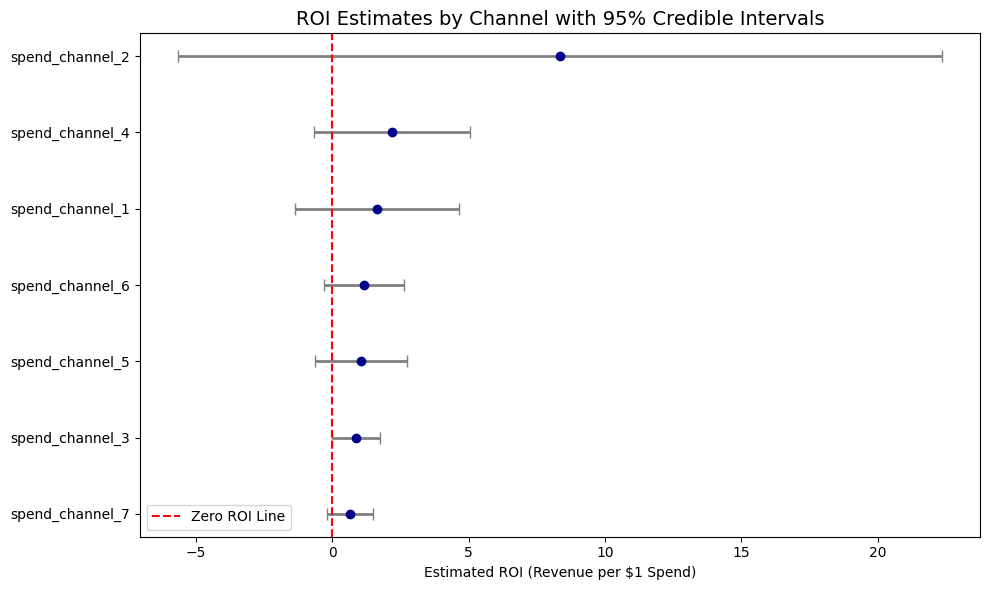

In [30]:
# Load the ROI table with uncertainty
roi_df = pd.read_csv(os.path.join(project_root,"output_files/MMM_ROI_uncertainty_data.csv"))

# Sort by ROI Mean
roi_sorted = roi_df.sort_values(by="ROI Mean", ascending=True)

# Plot forest plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    roi_sorted["ROI Mean"],
    roi_sorted["Channel"],
    xerr=1.96 * roi_sorted["ROI SD"],
    fmt='o',
    color='darkblue',
    ecolor='gray',
    elinewidth=2,
    capsize=4
)

# Reference line at zero
ax.axvline(x=0, color='red', linestyle='--', label="Zero ROI Line")

# Labels and title
ax.set_xlabel("Estimated ROI (Revenue per $1 Spend)")
ax.set_title("ROI Estimates by Channel with 95% Credible Intervals", fontsize=14)
ax.legend()
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(project_root,"output_files/ROI_Forest_Plot.png"), dpi=300)
plt.show()